<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/Preprocesado_datos_multitelescop/Interpretaci%C3%B3n_imagen_varios_telescopios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Queremos combinar la información de varios telescopios:
 Esa información extra que podamos sacar de varios telescopios esta destinada a dos propósitos:
 * Crear un clasificador general con mejor precisión.
 * Dar una estimación de la energía que ha tenido un evento, mediante el uso de pocos telescopios y suponiendo que la red sea capaz de reconstruir el evento.

In [ ]:
#importamos las librerias 
import matplotlib.pyplot as plt 
import numpy as np
import os 
import glob
import re
import pandas as pd
import matplotlib.cm as cm


In [ ]:
#rutas a los documentos de interes
gamma_tels_2_11="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma_variadito_telescopios_2_al_11"
gamma_tel_1="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma/gamma_dt"

Ahora vamos a escoger una RUN y vamos a trabajar con los datos que se conocen de esa desde todos los telescopios.

In [ ]:
#vamos listar las runs que tenemos para cada uno de los telecopios
runs_tel=[[] for i in range(11)]

#para el telescopio 1
lista_tel_1=glob.glob(f"{gamma_tel_1}/*.dt")
runs_tel[0]=sorted([float(re.findall(r"1_run_(\d\d)",i)[0]) for i in lista_tel_1])
lista_tel_2_11=glob.glob(f"{gamma_tels_2_11}/*.dt")
for j in range(2,12):
  #ESTO ESTA COMO UNA MIERDA, PERO NO SE USAR BIEN LAS FUNCIONES DE REGEX, y funciona
  lista_tel_2_11_aux=glob.glob(f"{gamma_tels_2_11}/*tel_{j}*.dt")
  runs_tel[j-1]=sorted([float(re.findall(r"_run_(\d\d)",i)[0]) for i in lista_tel_2_11_aux])

#ahora vamos a escoger aquellos que están en todos
interseccion_todos=set(runs_tel[0]).intersection(*runs_tel)
interseccion_todos

{1.0, 2.0}

Vamos a echarle un vistazo a varios eventos de las RUNS 1 y 2 en los telescopios.

In [ ]:
lista1=[]
for i in range(6,7):
  lista1.append(f'/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma_variadito_telescopios_2_al_11/gamma_tel_{i}_run_01.dt')

lista2=["/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma/gamma_dt/gamma_tel_1_run_01.dt"]

In [ ]:
try:
  os.remove("/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events")
except:
  pass
simple_dt_2_npy(lista1,"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events",
                limit_size=0.35,save_events_id=True)

In [ ]:
simple_dt_2_npy(lista1,"/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events",
                limit_size=0.35,save_events_id=True)

0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
#ahora vamos a hacer una funcion para el tratamiento de los datos de .dt a un .npy con los datos limpios y agrupaditos de una forma mas sencilla.

#tenemos que buscar una forma de que no guardemos archivos npy de mas de un giga (por poner un limite)
from tqdm.notebook import tqdm

#¿¿que hacer con la intensidad? si la normalozamos pierde significado??
#si procesamos todos los telescopios a la vez podriamos normalizar en relacion al evento completo. Aun asi dos eventos iguales en estructura pero uno siendo menos energetico
#se verían igual, de modo que habrá que mantener de alguna manera lo registrado por los detectores o algo.

def simple_dt_2_npy(files_names,npy_dir,limit_size=0.35,save_events_id=False):
  #ground_dir es el directorio base para las carpetas o para los archivos
  #npy_dir es el directorio para guardar todosl os .npy juntos, sin fantasia ni carpetas
  #folders=True es que los elementos .dt estan en carpetas
  #limit_size limite de peso en gigas de los .npy, por defecto esat en 350 Mb ó 0.35 Gigas

  #le añadimos la funcion de que cree un archivo que registra el identificador de cada evento, guardado en el mismo orden que las imagenes

  limit_size=limit_size*1e9 # pasamos de gigas a bytes 
  #tenemos que crear el directorio si aun no existe
  #os.mkdir(npy_dir)
  npy_dir_aux=npy_dir
  """
  k=0
  while os.path.isdir(npy_dir_aux):
    k+=1
    npy_dir_aux=npy_dir+f"_{k}"
  if not os.path.isdir(npy_dir_aux):
    os.mkdir(npy_dir_aux)
  """
  #creamos una lista con un dataframe por cada archivo
  for j in range(len(files_names)):
    dt_list=[]  
    contador_nombre=0
    print(j,end="\n")
    aux_df=pd.read_csv(files_names[j],sep='  ',names=["1","2","3","4","5","6"],engine="python")
    run_tel=re.findall(r"_(tel_[0-9]*_run_\d\d).dt",files_names[j])[0]
    #ahora la procesamos y la guardamos en un npy
    value_auf=aux_df[['1','3','4','5']].copy()
    del aux_df
    #tenemos que agupar los valores y normalizarlos 
    value_auf["5"].loc[value_auf["5"]<0]=0

    #es buena idea modificar los valores de la intensidad? quiza no

    max_aux=np.amax(value_auf["5"])
    value_auf["5"]=value_auf["5"]/max_aux
    x_minimo=min(value_auf['3'])
    y_minimo=min(value_auf['4'])
    events=value_auf["1"].unique()
    num_pix_x=value_auf["3"].unique().size
    num_pix_y=value_auf["4"].unique().size
    auxiliar=value_auf[value_auf["1"]==events[0]][["3","4","5"]].to_numpy()
    #ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel
    size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
    size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
    del auxiliar
    value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/size_pix_x))
    value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/size_pix_y))
    #event_aux=value_auf["1"].unique()
    for k in tqdm(range(np.shape(events)[0])):
      #cada evento tiene que ponerse en una imagen con sus valores
      array_aux=value_auf.loc[value_auf["1"]==events[k]][["3","4","5"]]
      #lo que vamos a hacer es poner los valores en una matriz creada de antemano y guardar esa matrix
      #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
      matrix_aux=np.zeros((num_pix_x,num_pix_y)) #eran 60-5= 55 y 131-38
      matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy() 
      dt_list.append(matrix_aux)
      if limit_size!=0:
        if (np.array(dt_list).nbytes>limit_size):
          name_npy=os.path.join(npy_dir_aux,f"{run_tel}_{contador_nombre}.npy")
          np.save(name_npy,np.array(dt_list))
          if save_events_id:
            name_npy_events=os.path.join(npy_dir_aux,f"id_eventos_{run_tel}_{contador_nombre}.npy")
            np.save(name_npy_events,np.array(events))
          del dt_list
          dt_list=[]
          contador_nombre+=1
    name_npy=os.path.join(npy_dir_aux,f"{run_tel}_{contador_nombre}.npy")
    np.save(name_npy,np.array(dt_list))
    if save_events_id:
      name_npy_events=os.path.join(npy_dir_aux,f"id_eventos_{run_tel}_{contador_nombre}.npy")
      np.save(name_npy_events,np.array(events))



In [ ]:
#ahora que tenemos los eventos y la ruta y to podemos representar esto
npy_dir="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events"
npy_events=sorted(glob.glob(npy_dir+"/id*.npy"))
npy=sorted(glob.glob(npy_dir+"/tel*.npy"))
aux=[]
for i in npy_events:
  aux.append(np.load(i))
imags=[]
for i in npy:
  imags.append(np.load(i))

In [ ]:
npy

['/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_1_run_01_0.npy',
 '/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_2_run_01_0.npy',
 '/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_3_run_01_0.npy',
 '/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_4_run_01_0.npy',
 '/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_5_run_01_0.npy',
 '/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/npy_events/tel_6_run_01_0.npy']

In [ ]:
#ahora representamos conjuntamente para las 4 telescopios (me he saltado el 1)
ruta="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/plt_tels_1_2_3_4_5_6_50_events"
os.mkdir(ruta)
orden=[1,2,3,6,4,5]
for evento in range(0,500,10):
  nombre=f"Telescopios_1_2_3_4_5_6_evento_{evento}.png"
  fig= plt.figure(figsize=(20,14))
  for i in range(0,6):
    plt.subplot(3,3,i+1)
    plt.imshow(imags[orden[i]-1][evento])
    plt.text(0.1,5.7,f"Telescopio {orden[i]}",fontsize=18)
    plt.xticks([])
    plt.yticks([])

  #vamos a representar la diferencia entre ellas
  plt.subplot(3,3,7)
  plt.imshow(abs(imags[0][evento]-imags[2][evento]),vmax=1)

  plt.subplot(3,3,8)
  plt.imshow(abs(imags[1][evento]-imags[3][evento]),vmax=1)

  plt.subplot(3,3,9)
  plt.imshow(abs(imags[4][evento]-imags[5][evento]),vmax=1)

  plt.tight_layout()
  fig.text(0.21,0.65,f"Evento {evento} en los telescopios 1,2,3,4,5 y 6",fontsize=30)
  fig.text(0.21,0.33,f"Diferencia entre las imagenes de 1-6 , 2-4 y 3-5 ",fontsize=30)

  plt.savefig(os.path.join(ruta,nombre))
  plt.close()

In [ ]:
#vamos a investigar las posiciones espaciales de los telescopios
txt_gamma="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/gamma_tel_1_run_01.txt"
posiciones_telescopios=[]

#vamos a mirar las configuraciones según los diferentes nombres, a ver
nombre_configuracion=""
#tambien tenemos tres tipos de telescopios 1-11 LSTS | 12-52 MSTS | 53-210 SST

ultimo=0
nuevo=0
with open(txt_gamma) as txt_file:
  for line in txt_file:
    if ("# TELESCOPE" in line)and (nombre_configuracion in line):
      line=line.split()
      #vamos a añadir una columna para el tipo de telescopio grande=3, mediano=2, peque=1
      if int(line[7]) in range(1,12):
        tipo=3.3
      elif int(line[7]) in range(12,53):
        tipo=1.7
      elif int(line[7]) in range(53,211):
        tipo=1
      aux_list=np.array([int(line[7]),float(line[1]),float(line[2]),tipo])
      nuevo=int(line[7])
      #solo queremos guardarlo una vez, de todas las que haya, cuando hayamos llegado al ultimo nos salimos
      if ultimo >= nuevo:
        break
      ultimo=nuevo
      posiciones_telescopios.append(aux_list)

posiciones_telescopios=np.array(posiciones_telescopios)

Text(0.05, 0.95, '')

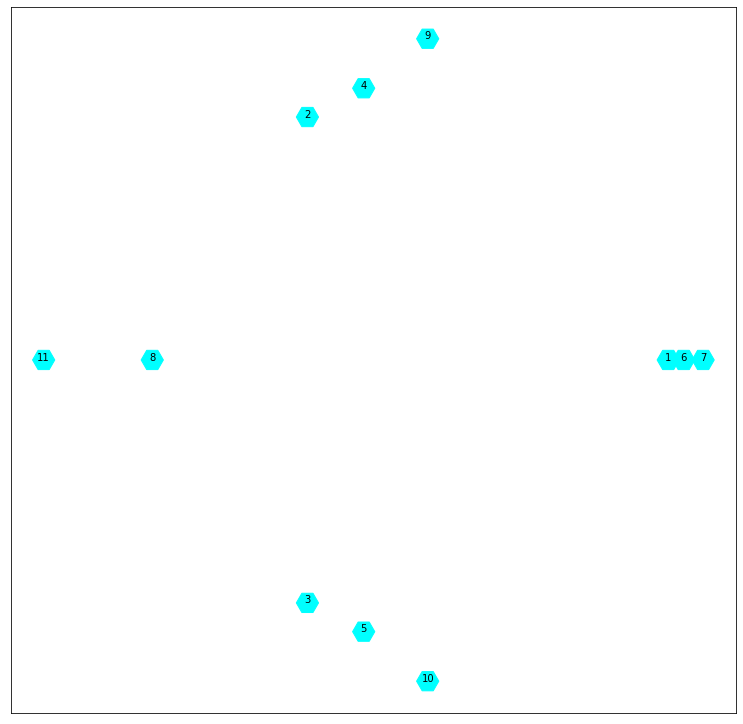

In [ ]:
#posicion de los 11 primeros telescopios

#vamos a investigar las posiciones espaciales de los telescopios
txt_gamma="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/gamma_tel_1_run_01.txt"
posiciones_telescopios=[]

#vamos a mirar las configuraciones según los diferentes nombres, a ver
nombre_configuracion=""
#tambien tenemos tres tipos de telescopios 1-11 LSTS | 12-52 MSTS | 53-210 SST

ultimo=12
nuevo=0
with open(txt_gamma) as txt_file:
  for line in txt_file:
    if ("# TELESCOPE" in line)and (nombre_configuracion in line):
      line=line.split()
      #vamos a añadir una columna para el tipo de telescopio grande=3, mediano=2, peque=1
      if int(line[7]) in range(1,12):
        tipo=3.3
      elif int(line[7]) in range(12,53):
        tipo=1.7
      elif int(line[7]) in range(53,211):
        tipo=1
      aux_list=np.array([int(line[7]),float(line[1]),float(line[2]),tipo])
      nuevo=int(line[7])
      #solo queremos guardarlo una vez, de todas las que haya, cuando hayamos llegado al ultimo nos salimos
      if nuevo >= ultimo:
        break
      posiciones_telescopios.append(aux_list)

posiciones_telescopios=np.array(posiciones_telescopios)


plt.figure(figsize=(13,13))
plt.scatter(posiciones_telescopios[:,1],posiciones_telescopios[:,2],s=posiciones_telescopios[:,3]*150,c=posiciones_telescopios[:,3],marker="H",cmap=cm.cool)
plt.xticks([])
plt.yticks([])
for i,j in enumerate(zip(posiciones_telescopios[:,1],posiciones_telescopios[:,2])):
  text=posiciones_telescopios[:,0].astype(int).astype(str)[i]
  plt.annotate(text,xy=j,ha="center")
ax=plt.gca()
plt.text(0.05,0.95,nombre_configuracion,fontsize=30,transform = ax.transAxes)

Text(0.05, 0.95, '[3HB2-2]')

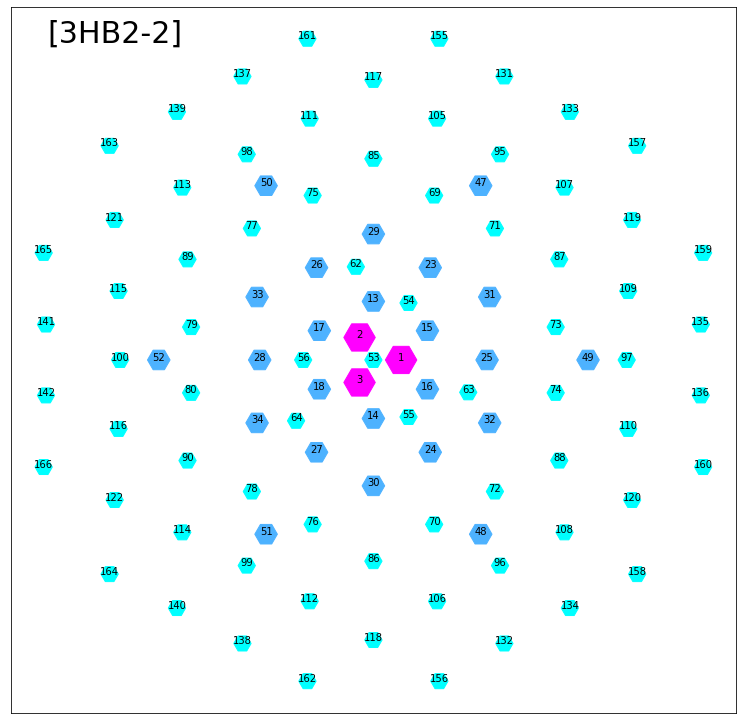

In [ ]:
#ahora vamos a imprimir las posiciones de los telescopios en forma de scattering

plt.figure(figsize=(13,13))
plt.scatter(posiciones_telescopios[:,1],posiciones_telescopios[:,2],s=posiciones_telescopios[:,3]*300,c=posiciones_telescopios[:,3],marker="H",cmap=cm.cool)
plt.xticks([])
plt.yticks([])
for i,j in enumerate(zip(posiciones_telescopios[:,1],posiciones_telescopios[:,2])):
  text=posiciones_telescopios[:,0].astype(int).astype(str)[i]
  plt.annotate(text,xy=j,ha="center")
ax=plt.gca()
plt.text(0.05,0.95,nombre_configuracion,fontsize=30,transform = ax.transAxes)

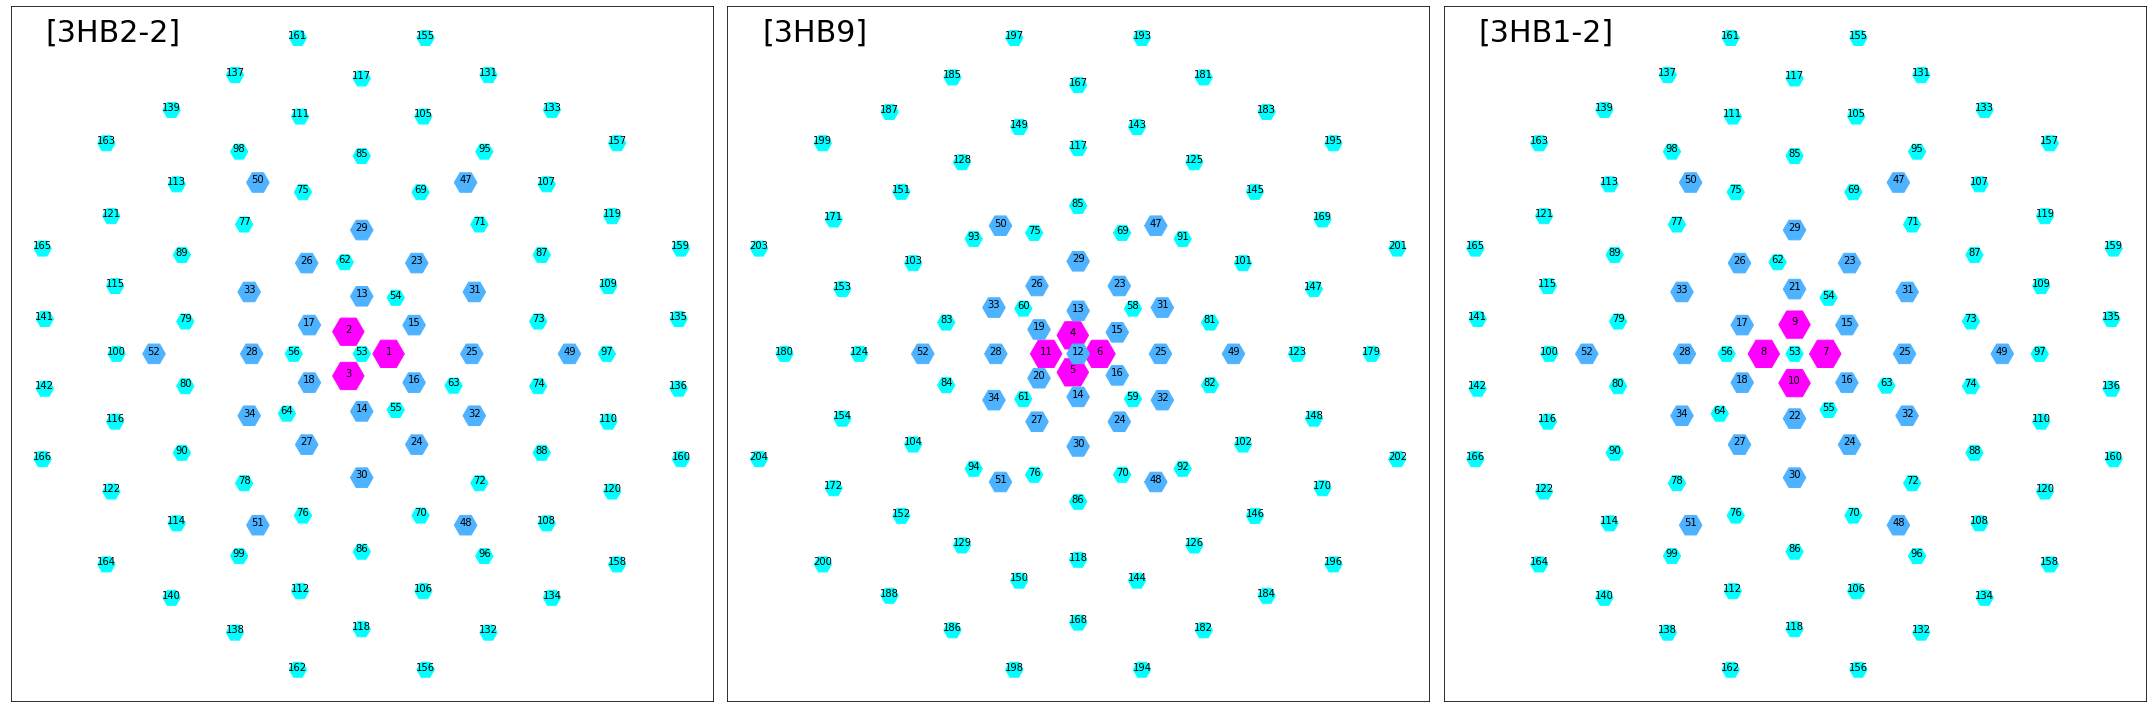

In [ ]:
#REPETICION DE CELDAS ANTERIORES PERO AHORA TODO JUNTO Y AUTOMATIZADO

#vamos a investigar las posiciones espaciales de los telescopios
txt_gamma="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/gamma_tel_1_run_01.txt"


#vamos a mirar las configuraciones según los diferentes nombres, a ver
lista_nombre_configuraciones=["[3HB2-2]","[3HB9]","[3HB1-2]"]
#tambien tenemos tres tipos de telescopios 1-11 LSTS | 12-52 MSTS | 53-210 SST
plt.figure(figsize=(30,10))

for num_plot,k in enumerate(lista_nombre_configuraciones):
  posiciones_telescopios=[]
  ultimo=0
  nuevo=0
  with open(txt_gamma) as txt_file:
    for line in txt_file:
      if ("# TELESCOPE" in line)and (k in line):
        line=line.split()
        #vamos a añadir una columna para el tipo de telescopio grande=3, mediano=2, peque=1
        if int(line[7]) in range(1,12):
          tipo=3.3
        elif int(line[7]) in range(12,53):
          tipo=1.7
        elif int(line[7]) in range(53,211):
          tipo=1
        aux_list=np.array([int(line[7]),float(line[1]),float(line[2]),tipo])
        nuevo=int(line[7])
        #solo queremos guardarlo una vez, de todas las que haya, cuando hayamos llegado al ultimo nos salimos
        if ultimo >= nuevo:
          break
        ultimo=nuevo
        posiciones_telescopios.append(aux_list)

  posiciones_telescopios=np.array(posiciones_telescopios)

  #ahora vamos a imprimir las posiciones de los telescopios en forma de scattering
  plt.subplot(1,3,num_plot+1)
  plt.scatter(posiciones_telescopios[:,1],posiciones_telescopios[:,2],s=posiciones_telescopios[:,3]*300,c=posiciones_telescopios[:,3],marker="H",cmap=cm.cool)
  plt.xticks([])
  plt.yticks([])
  for i,j in enumerate(zip(posiciones_telescopios[:,1],posiciones_telescopios[:,2])):
    text=posiciones_telescopios[:,0].astype(int).astype(str)[i]
    plt.annotate(text,xy=j,ha="center")
  ax=plt.gca()
  plt.text(0.05,0.95,k,fontsize=30,transform = ax.transAxes)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/distr_mas_imp_telesc.png")